# 分析测试文件

## 设置置信度阈值

### 不加阈值时的表现

读取预测文件

In [1]:
import os
import json

with open("test_conll03.txt", "r", encoding="utf-8") as f:
    lines = f.readlines()

评估预测表现

In [2]:
num_true_entities = 0
num_pred_entities = 0
num_correct_entities = 0
prob_list = []

for i in range(len(lines)):
    if i % 9 == 0:
        true_entities = eval(lines[i + 3].strip())
        predicted_entities = eval(lines[i + 5].strip())
        predicted_probs = eval(lines[i + 7].strip())
        
        num_true_entities += len(true_entities)
        num_pred_entities += len(predicted_entities)
        prob_list.extend(predicted_probs)
        
        for entity in true_entities:
            if entity in predicted_entities:
                num_correct_entities += 1

print("num_true_entities: {}".format(num_true_entities))
print("num_pred_entities: {}".format(num_pred_entities))
print("num_correct_entities: {}".format(num_correct_entities))

num_true_entities: 5648
num_pred_entities: 5702
num_correct_entities: 5247


查看一下实体概率的分布

In [3]:
# len(prob_list)  # 5702, 和预测出来的实体数目一致，没有问题
import pandas as pd

df = pd.DataFrame({'prob': prob_list})

In [4]:
df.describe()

,prob
count,5702.000000
mean,0.985121
std,0.070582
min,0.289225
25%,0.999856
50%,0.999986
75%,0.999999
max,1.000000


In [5]:
# from utils import cal_f1

precision = num_correct_entities / num_pred_entities
recall = num_correct_entities / num_true_entities
f = 2 * precision * recall / (precision + recall) if precision and recall else 0
print("precision: {}".format(precision))
print("recall: {}".format(recall))
print("f: {}".format(f))

precision: 0.9202034373903893
recall: 0.9290014164305949
f: 0.9245814977973569


In [6]:
def cal_f1(num_correct, num_pred, num_real):
    """ 
    根据实际实体数量, 预测实体数量, 预测正确的实体数量计算f1值
    input:
        num_correct (int): 预测正确的实体数量
        num_pred (int): 预测的实体数量
        num_real (int): 实际的实体数量
    output:
        precision (float): 预测正确的实体数量/预测的实体数量
        recall (float): 预测正确的实体数量/实际的实体数量
        f (float): 2 * precision * recall / (precision + recall)
    """
    if num_real == 0 or num_pred == 0 or num_correct == 0:
        return 0, 0, 0

    recall = num_correct / num_real
    precision = num_correct / num_pred
    f = 0
    if recall and precision:
        f =  2 * precision * recall / (precision + recall)
    
    return precision, recall, f

In [7]:
cal_f1(num_correct=num_correct_entities, num_pred=num_pred_entities, num_real=num_true_entities)

(0.9202034373903893, 0.9290014164305949, 0.9245814977973569)

### 加阈值时的表现

In [8]:
def get_performance(predict_file, threshold):
    """ 
    根据预测文件和设定的阈值, 评估模型的表现
    input:
        predict_file (str): 预测文件路径
        threshold (float): 阈值
    output:
        precision (float): 预测正确的实体数量/预测的实体数量
        recall (float): 预测正确的实体数量/实际的实体数量
        f (float): 2 * precision * recall / (precision + recall)
    """
    
    with open(predict_file, "r", encoding="utf-8") as f:
        lines = f.readlines()
        
    num_true_entities = 0
    num_pred_entities = 0
    num_correct_entities = 0

    for i in range(len(lines)):
        if i % 9 == 0:
            true_entities = eval(lines[i + 3].strip())
            predicted_entities = eval(lines[i + 5].strip())
            predicted_probs = eval(lines[i + 7].strip())
            
            # 筛选出大于阈值的预测结果
            predicted_entities = [entity for entity, prob in zip(predicted_entities, predicted_probs) if prob >= threshold]
            
            num_true_entities += len(true_entities)
            num_pred_entities += len(predicted_entities)
            
            for entity in true_entities:
                if entity in predicted_entities:
                    num_correct_entities += 1
    print("num_true_entities: {}".format(num_true_entities))
    print("num_pred_entities: {}".format(num_pred_entities))
    print("num_correct_entities: {}".format(num_correct_entities))
    precision, recall, f = cal_f1(num_correct=num_correct_entities, num_pred=num_pred_entities, num_real=num_true_entities)
    
    return precision, recall, f

In [10]:
import prettytable as pt
table = pt.PrettyTable(["Precision", "Recall", "F1", "Threshold"])

thresholds = [0.2, 0.5, 0.9, 0.95, 0.98, 0.99]
precision_list = []
recall_list = []
f_list = []

for threshold in thresholds:
    precision, recall, f = get_performance(predict_file="test_conll03.txt", threshold=threshold)
    precision_list.append(precision)
    recall_list.append(recall)
    f_list.append(f)
    
    table.add_row([precision, recall, f, threshold])

print(table)    

num_true_entities: 5648
num_pred_entities: 5702
num_correct_entities: 5247
num_true_entities: 5648
num_pred_entities: 5669
num_correct_entities: 5237
num_true_entities: 5648
num_pred_entities: 5467
num_correct_entities: 5154
num_true_entities: 5648
num_pred_entities: 5377
num_correct_entities: 5102
num_true_entities: 5648
num_pred_entities: 5286
num_correct_entities: 5051
num_true_entities: 5648
num_pred_entities: 5208
num_correct_entities: 4990
+--------------------+--------------------+--------------------+-----------+
|     Precision      |       Recall       |         F1         | Threshold |
+--------------------+--------------------+--------------------+-----------+
| 0.9202034373903893 | 0.9290014164305949 | 0.9245814977973569 |    0.2    |
| 0.923796083965426  | 0.9272308781869688 | 0.9255102942475921 |    0.5    |
| 0.9427473934516188 | 0.9125354107648725 | 0.9273954116059379 |    0.9    |
| 0.9488562395387763 | 0.9033286118980169 | 0.925532879818594  |    0.95   |
| 0.9555429

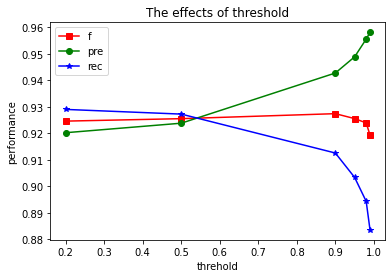

In [16]:
import matplotlib.pyplot as plt

#折线图
x = thresholds#点的横坐标
y1 = f_list 
y2 = precision_list
y3 = recall_list
plt.plot(x, y1, 's-', color='r', label="f") #s-:方形
plt.plot(x, y2, 'o-', color='g', label="pre") #o-:圆形
plt.plot(x, y3, '*-', color='b', label="rec") #*-:方形
plt.xlabel("threhold")  #横坐标名字
plt.ylabel("performance")   #纵坐标名字
plt.legend(loc="best")  #图例
plt.title("The effects of threshold")  #标题
plt.show()